# SimCADO imager simulation
This notebook is adapted from the example notebooks in SimCADO document: https://simcado.readthedocs.io/en/latest/user_docs/6_Examples_Tutorials.html

In [44]:
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from astropy.io import fits

import simcado
from simcado.source import *
from simcado import __data_dir__
print("SimCADO data directory is", __data_dir__)

import photutils

SimCADO data directory is /Users/spacegrey/opt/anaconda3/envs/simelt/lib/python3.9/site-packages/simcado/data


## Create source from fits file

In [376]:
# Import fits image
model = './5ext/npix173/'
d = 100 # pc
layout = 'small'
mode, micado_pixscale = 'zoom', 0.0015
#mode, micado_pixscale = 'wide', 0.004

with fits.open(model+'image2.fits') as inhdul:
    sourceimg = inhdul[0].data[0]
    sourcehdr = inhdul[0].header
try:
    print("Pixel unit:", sourcehdr['UNITS'])
except:
    print("Pixel unit:", sourcehdr['BUNIT'])

Pixel unit: Jy / pixel


size of the image: (173, 173)
range of the image: 0.5023764239832432 and 0.0


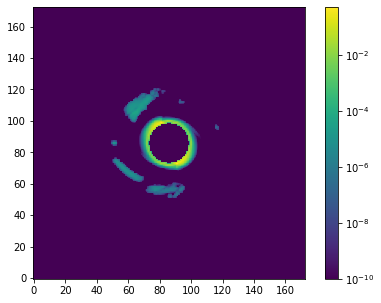

In [377]:
# Plot fits image
fig = plt.figure(figsize=(7,5))
image = sourceimg

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(image, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-10))

plt.colorbar()
print("size of the image:", image.shape)
print("range of the image:", image.max(),"and", image.min())

In [378]:
# Check image pixel scale
try:
    pixscale = sourcehdr['CDELT1'] * -3600
except:
    pixscale = sourcehdr['CD1_1'] * -3600

# If image pixscale not the same as the detector pixscale, need to specify oversample to interpolate between the two scales. 
oversample = pixscale / micado_pixscale

print("Image pixel scale:", pixscale, "arcsec/pixel, oversample:", oversample)

Image pixel scale: 0.001502910265793616 arcsec/pixel, oversample: 1.001940177195744


In [379]:
# Read spectrum (function from radmc3dpy)
def readSpectrum(fname):
    with open(fname, 'r') as rfile:
        # Read the format number
        dum = rfile.readline()
        # Read the number of wavelengths
        nwav = int(rfile.readline())
        # Read a blank line
        dum = rfile.readline()

        res = np.zeros([nwav, 2], dtype=np.float64)
        for iwav in range(nwav):
            dum = rfile.readline().split()
            res[iwav, 0] = float(dum[0])
            res[iwav, 1] = float(dum[1])
    return res

spectrum = readSpectrum(model+'spectrum.out')
wav = spectrum[:,0]
spec = spectrum[:,1] * 1e23 / d ** 2      # Conversion from erg s-1 cm-2 Hz-1 to Jy at d pc

Simcado takes spectrum input with unit photons/(m2 s bin). Compute $f_{\lambda}$, the number of ph/(m2 s um) that correspond to 1 Jy at $\lambda_{\mathrm{ref}}$, and the input $flux$\[ph/(m2 s bin)\] = $spec$\[Jy\] $\times \ \ f_{\lambda}$\[ph/(m2 s um)/Jy\] $\times \ \ dlam$\[um/bin\] 

In [380]:
# Convert flux level (adapted from SIMMetis example notebook)
from astropy import units as u
lam_ref = 2 * u.um
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                         equivalencies=u.spectral_density(lam_ref))
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, flam_ref))

dlam = np.zeros(len(wav)-1)  # [um], spectral bin width
for i in range(len(wav)-1):
    dlam[i] = wav[i+1] - wav[i]
flux = spec[:-1] * flam_ref.value * dlam
lam = wav[:-1]
print(flux)

1 Jy at  2.00 um corresponds to 7545950.90 ph / (m2 s um)
[1.10629411e+04 1.16130456e+05 1.21448405e+05 1.27634997e+05
 1.34829573e+05 1.43250426e+05 1.53264749e+05 1.64946585e+05
 1.78924951e+05 1.95356904e+05 2.14734331e+05 2.37703508e+05
 2.64606447e+05 2.96308633e+05 3.33453632e+05 3.76607718e+05
 4.26928641e+05 4.85135084e+05 5.52515916e+05 6.29736827e+05
 7.18631269e+05 8.20009050e+05 9.35163971e+05 1.06625777e+06
 1.21416659e+06 1.38072557e+06 1.56799202e+06 1.77705696e+06
 2.01047609e+06 2.27028531e+06 2.55804074e+06 2.87568033e+06
 3.22513860e+06 3.60977417e+06 4.03044534e+06 4.48993595e+06
 4.98945400e+06 5.53176927e+06 6.11997388e+06 6.75398245e+06
 7.43655700e+06 8.16940618e+06 8.95406050e+06 9.79504106e+06
 1.06877670e+07 1.16394676e+07 1.26480529e+07 1.37143150e+07
 1.48427551e+07 1.60275972e+07 1.72754495e+07 1.85817340e+07
 1.99506262e+07 2.13795140e+07 2.28654555e+07 2.44158151e+07
 2.60203781e+07 2.76829482e+07 2.94025283e+07 3.11739041e+07
 3.29981137e+07 3.48721290e

In [381]:
# Creating the source
src_disk = source_from_image(image, lam, flux, # spectra in [ph/s/m2/bin]
                                    plate_scale=pixscale, # The plate scale of the simulated image
                                    oversample=oversample) 


In [382]:
# Runing the simulation with two hours of exposure time
t_long = 3600 * 2  # second
t_short = 2 
sim_image_2h = simcado.run(src_disk, mode=mode, detector_layout=layout, filter_name='Ks2', OBS_NDIT=1, OBS_DIT=t_long)
sim_image_2s = simcado.run(src_disk, mode=mode, OBS_NDIT=1, filter_name='Ks2' , OBS_DIT=t_short)


Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 8 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 7200    NDIT = 1
Detector layout
 id x_cen y_cen xhw  yhw  x_len y_len pixsize angle gain
--- ----- ----- ---- ---- ----- ----- ------- ----- ----
  1   0.0   0.0 7.68 7.68  1024  1024   0.015   0.0  1.0
Creating 8 layer(s) per chip
1 chip(s) will be simulated
Generating image for chip 1
Reading out chip 1 using superfast
DIT = 2    NDIT = 1


pixel scale is 1.500000000000012 mas/pix


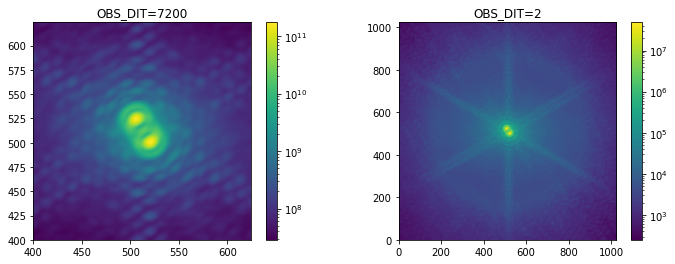

In [395]:
extent = (xmin, xmax, ymin, ymax) = (400, 624, 400, 624)      # small, zoom
#extent = (xmin, xmax, ymin, ymax) = (100, 924, 100, 924)
#extent = (xmin, xmax, ymin, ymax) = (1600, 2496, 1600, 2496)  # centre, wide
#extent = (xmin, xmax, ymin, ymax) = (1000, 3096, 1000, 3096)  # centre, zoom

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
im1=ax1.imshow(sim_image_2h[0].data[xmin:xmax, ymin:ymax], extent=extent, norm=LogNorm(),origin="lower")
#im1=ax1.imshow(sim_image_2h[0].data, norm=LogNorm(),origin="lower")
im2=ax2.imshow(sim_image_2s[0].data, norm=LogNorm(), origin='lower')
fig.colorbar(im1, ax=ax1)
ax1.set_title("OBS_DIT=7200")
fig.colorbar(im2, ax=ax2)
ax2.set_title("OBS_DIT=2")
print('pixel scale is', sim_image_2s[0].header['CDELT1'] * 3600 * 1000, 'mas/pix')

In [93]:
sim_image_2h.writeto(model+'MICADO_2h.fits', overwrite=True)

## Additional checks

(173, 173)

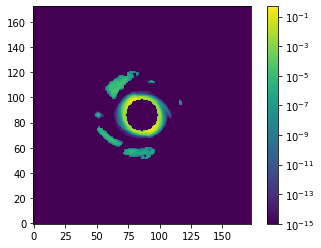

In [394]:
# Check oversampled image
oversample = 1
import scipy.ndimage.interpolation as spi
newimg = spi.zoom(image, oversample, order=3)
plt.imshow(newimg, origin="lower", cmap=cmap, norm=LogNorm(vmin=1e-15))
plt.colorbar()
newimg.shape

['K-short', 'xH2', 'R', 'J-short', 'xH1', 'K-cont', 'Ks', 'Ks2', 'U', 'B', 'xI1', 'V', 'H-long', 'I-long', 'xI2', 'Spec_HK', 'xJ2', 'Y', 'Br-gamma', 'He-I', 'xJ1', 'xK1', 'J', 'xK2', 'H', 'Spec_IJ', 'K-mid', 'I', 'xY1', 'K-long', 'J-long', 'H2_1-0S1', 'xY2', 'H-short', 'Pa-beta', 'H-cont', 'FeII']


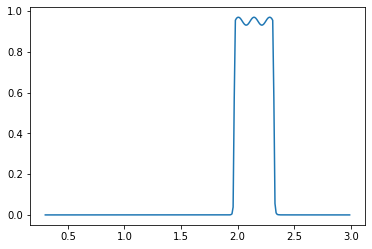

In [261]:
# View filter
print(simcado.optics.get_filter_set())
T_curve = simcado.optics.get_filter_curve('Ks2')
T_curve.plot()